<a href="https://colab.research.google.com/github/zhavzharik/21BetaTest_DS_Healthcare/blob/main/Project_02_%E2%80%93_Predicting_heart_rate_as_a_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключаем библиотеки

In [ ]:
!pip install --upgrade git+https://github.com/statsmodels/statsmodels
!pip install pmdarima

  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-snqndx2x
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-snqndx2x
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 233 kB 5.4 MB/s 
  Created wheel for statsmodels: filename=statsmodels-0.14.0.dev0-cp37-cp37m-linux_x86_64.whl size=17839825 sha256=77d796d17a802b97b5be767ba8de64ec0adcc38ad2be0b17d170efbd93aba0f0
  Stored in directory: /tmp/pip-ephem-wheel-cache-87xq5que/wheels/a7/e2/12/87eac3fb9bcec178a4228e24f5d4c0996208883c6f1b44e941
Successfully built statsmodels
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:
      Successfully uninstalled patsy-0.5.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully un

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import  mean_squared_error, mean_absolute_error
from math import sqrt
import time
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.utils import plot_model



%matplotlib inline

In [ ]:
# сброс ограничений на число выводимых столбцов
pd.set_option('display.max_columns', None)

In [ ]:
# подключаем гугл диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Analysis

In [ ]:
# читаем данные (9-я группа)
data9 = pd.read_csv('/content/drive/MyDrive/DS_healthcare_21/normal/N9', header=None, sep=' ', parse_dates={'time':[0]}, index_col=0)
data9.rename(columns = {1: 'heart_rate'}, inplace=True)

In [ ]:
# посмотрим первые пять строк
data9.head()

,heart_rate
time,
45001.961,96.0000
45002.570,98.5222
45003.164,101.0100
45003.758,101.0100
45004.344,102.3890


In [ ]:
# функция преобразования даты, передискретизации данных
def convert_data(data):
    data['time_minutes'] = [timedelta(seconds=j).total_seconds() / 60 for j in data.index]
    data.index = [timedelta(seconds=j) for j in data.index]
    # проведем передискретизацию данных с минутными интервалами (среднее значение)
    data_res_mean = data.drop(columns=['time_minutes']).resample('min').mean()
    # проведем передискретизацию данных с минутными интервалами (прямое заполнение последними ивестными значениями)
    data_res_ffill = data.drop(columns=['time_minutes']).resample('min').ffill()
    return data, data_res_mean, data_res_ffill

In [ ]:
# функция визуализации данных
def display_data(data, data_res_mean, data_res_ffill):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10), dpi=400)
    ax[0,0].scatter(data.time_minutes, data.heart_rate)
    ax[0,0].set_xlabel('Время, прошедшее с начала записи (минуты)')
    ax[0,0].set_ylabel('Частота сердечных сокращений (удары в минуту)')
    ax[0,0].set_title("Частота сердечного ритма во время сна (измерения в 9-й группе)")
    autocorrelation_plot(data.heart_rate, ax=ax[0,1])
    ax[0,1].set_title("Автокорреляция")
    ax[1,0].plot(data_res_mean, label='heart_rate') # визуализируем средние значения с минутными интервалами
    ax[1,0].set_title("Средние значения сердечного ритма (минутный интервал)")
    ax[1,1].plot(data_res_ffill, color='r', label='heart_rate')
    ax[1,1].plot(data_res_ffill.rolling(30).mean(), 'k--', label='rolling_mean') # экспоненциально взвешенное скользящее среднее
    ax[1,1].plot(data_res_ffill.expanding().mean(), label='expanding_mean') # среднее с расширяющимся окном
    ax[1,1].set_title("Последние значения сердечного (минутный интервал)")
    plt.legend(loc='best')

In [ ]:
# функция анализа данных
def data_analysis(data):
    new_data, data_res_mean, data_res_ffill = convert_data(data) 
    display_data(new_data, data_res_mean, data_res_ffill)
    # display_data_min(new_data)
    # data_res_mean.plot(figsize=(8,6)) # переписать
    # display_resample_data(data_res_ffill)
    return new_data, data_res_mean, data_res_ffill   

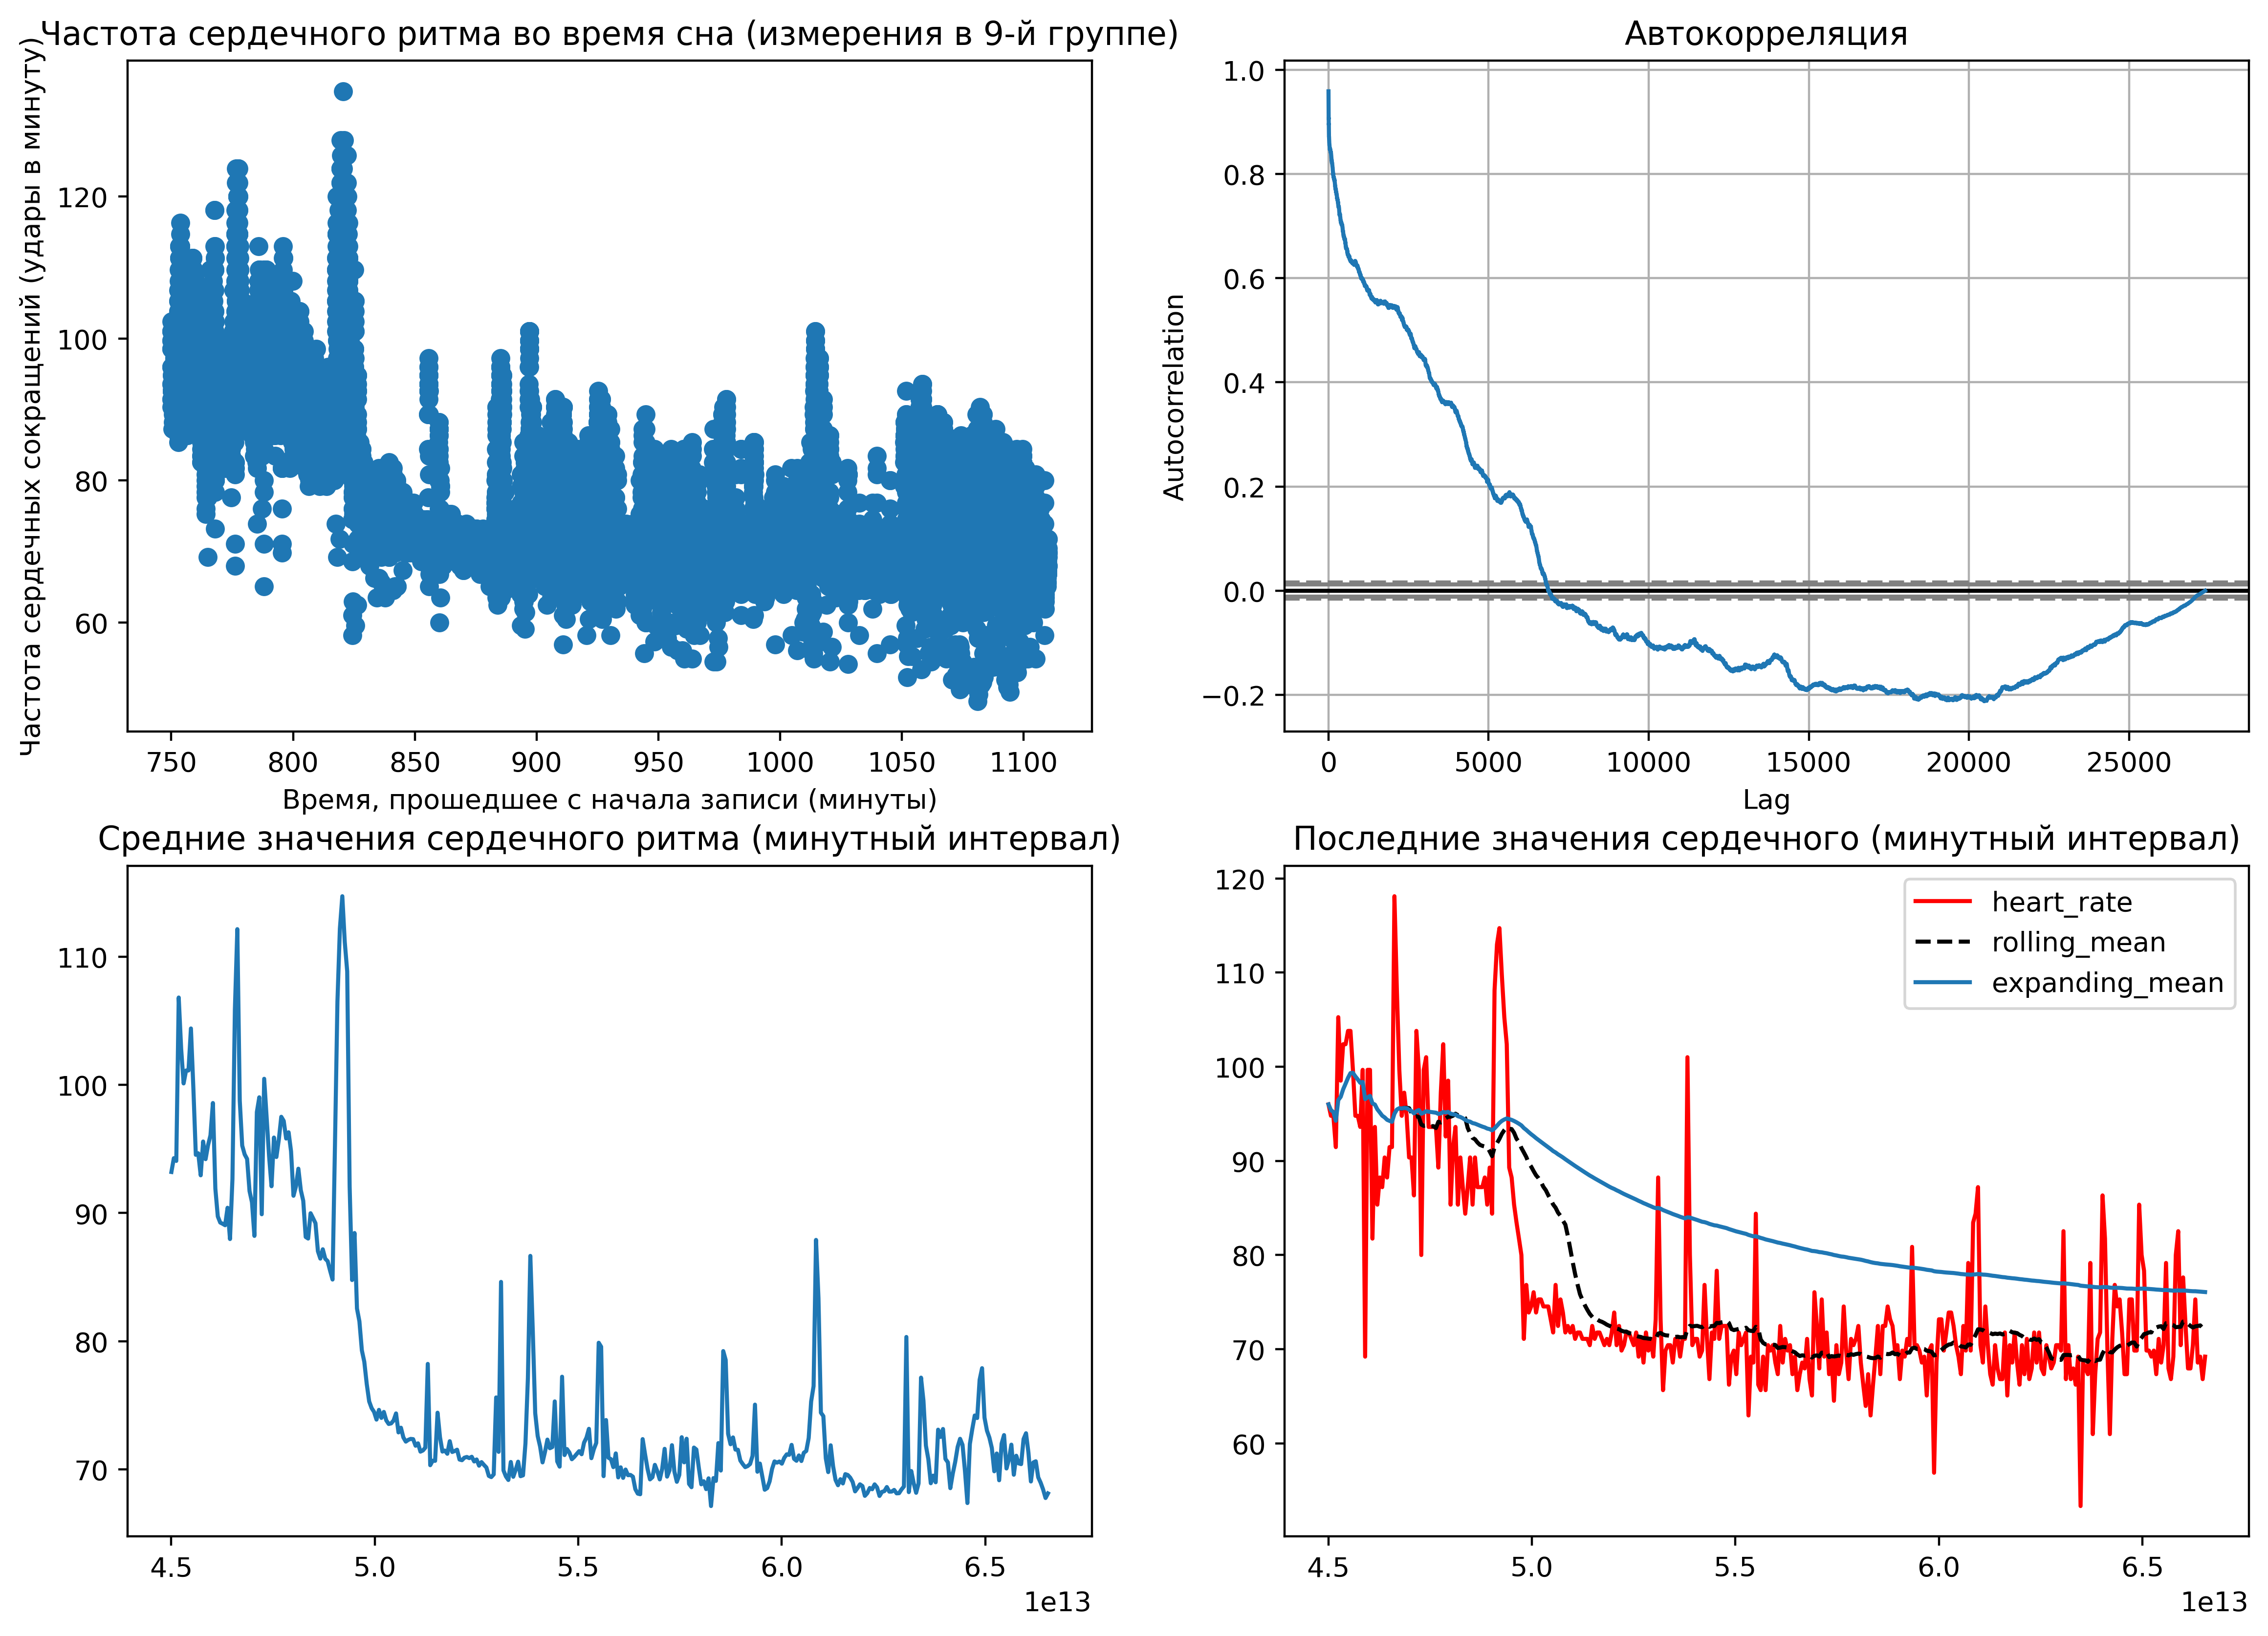

In [ ]:
new_data, data_res_mean, data_res_ffill = data_analysis(data9)

In [ ]:
print(f'Количество измерений в девятой группе: {data9.shape[0]}')

Количество измерений в девятой группе: 27374


In [ ]:
data_res_mean.describe()

,heart_rate
count,360.000000
mean,76.439966
std,10.433733
min,67.136004
25%,69.897319
50%,71.529946
75%,78.267323
max,114.718401


In [ ]:
data_res_ffill.describe()

,heart_rate
count,360.000000
mean,76.064900
std,11.096722
min,53.333300
25%,69.204200
50%,71.090000
75%,80.000000
max,118.110000


In [ ]:
data_copy = data_res_mean.copy()

# Data Preparation

In [ ]:
# разделим данные на тренировочную и тестовую выборки
X = data_res_mean.values
valLen = 130
trainLen = len(X) - valLen
xTrain, xTest = X[0:trainLen], X[trainLen:len(X)]

In [ ]:
print(f'Размер обучающей выборки: {xTrain.shape}')
print(f'Размер тестовой выборки: {xTest.shape}')

Размер обучающей выборки: (230, 1)
Размер тестовой выборки: (130, 1)


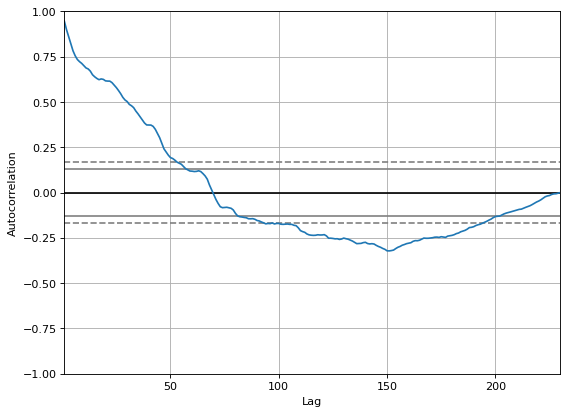

In [ ]:
# посмотрим на график автокорреляции временного ряда обучающей выборки
plt.figure(figsize=(8,6), dpi=80)
autocorrelation_plot(xTrain)
plt.show()

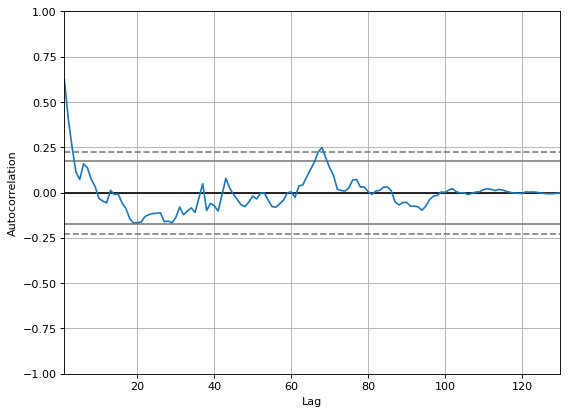

In [ ]:
# посмотрим на график автокорреляции временного ряда тестовой выборки
plt.figure(figsize=(8,6), dpi=80)
autocorrelation_plot(xTest)
plt.show()

# Statistical Models

ARIMA

predicted = 71.63063948833263, expected = [72.49014028]
predicted = 71.3275531278473, expected = [71.53929167]
predicted = 71.35895384451406, expected = [71.52821549]
predicted = 71.51608300607, expected = [70.68794225]
predicted = 70.73811386393254, expected = [70.40887429]
predicted = 70.98855473388275, expected = [70.17245286]
predicted = 70.85970147613018, expected = [70.25542571]
predicted = 69.64941849348259, expected = [70.41858451]
predicted = 70.94281692236666, expected = [71.05623944]
predicted = 71.8349543755, expected = [75.04826622]
predicted = 73.65312403971822, expected = [69.81266]
predicted = 69.49709159594565, expected = [70.45093571]
predicted = 70.86792669588255, expected = [69.44225571]
predicted = 68.96613526212226, expected = [68.408475]
predicted = 69.19379520244144, expected = [68.53639565]
predicted = 70.28341108184779, expected = [69.06204783]
predicted = 68.41927485147887, expected = [70.03448]
predicted = 70.11077855485527, expected = [70.61864714]
predicte

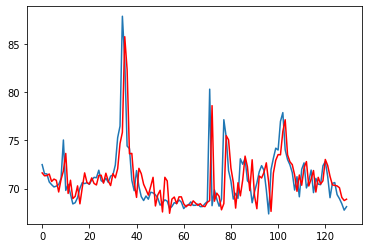

In [ ]:
# построим модель ARIMA, найдем RMSE, MAE, расчитаем время обучения и прогноза, визуализируем предсказание и ожидаемый результат
history = [x for x in xTrain]
predictions =list()
train_time = 0
predict_time = 0
for t in range(len(xTest)):
    start = time.time()
    model = ARIMA(history, order=(20,1,0))
    model_fit = model.fit()
    end = time.time()
    train_time += (end - start)
    start = time.time()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    end = time.time()
    predict_time += (end - start)
    obs = xTest[t]
    history.append(obs)
    print(f'predicted = {yhat}, expected = {obs}')    
rmse = sqrt(mean_squared_error(xTest, predictions))
mae = mean_absolute_error(xTest, predictions)
print(f'Время обучения {round(train_time / 60, 2)} минут')
print(f'Время прогноза {round(predict_time / 60, 2)} минут')
print(f'Test RMSE: {round(rmse, 3)}')
print(f'Test MAE: {round(mae, 3)}')
plt.plot(xTest)
plt.plot(predictions, color='red')
plt.show()


Подбор гиперпараметров ARIMA

In [ ]:
def evaluate_arima_model(X, arima_order):
    valLen = 130
    trainLen = len(X) - valLen
    xTrain, xTest = X[0:trainLen], X[trainLen:len(X)]
    history = [x for x in xTrain]
    predictions =list()
    train_time = 0
    predict_time = 0
    for t in range(len(xTest)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = xTest[t]
        history.append(obs)        
    rmse = sqrt(mean_squared_error(xTest, predictions))
    mae = mean_absolute_error(xTest, predictions)
    return rmse, mae

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_mae, best_cfg = float("inf"), float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse, mae = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_mae, best_cfg = rmse, mae, order
                    print(f'ARIMA {order} RMSE = {round(rmse, 3)}, MAE = {round(mae, 3)}')
                except:
                    continue
    print(f'Best ARIMA {best_cfg} RMSE = {round(best_score, 3)}, MAE = {round(best_mae, 3)}')

In [ ]:
p_values = [0, 5, 10, 20, 40, 60]
d_values = range(0,3)
q_values = range(0,3)

In [ ]:
evaluate_models(data_res.values, p_values, d_values, q_values)

ARIMA (0, 0, 0) RMSE = 7.549, MAE = 7.182
ARIMA (0, 0, 1) RMSE = 4.832, MAE = 4.315
ARIMA (0, 0, 2) RMSE = 3.908, MAE = 3.246
ARIMA (0, 1, 0) RMSE = 2.538, MAE = 1.391
ARIMA (0, 1, 1) RMSE = 2.5, MAE = 1.373
ARIMA (0, 1, 2) RMSE = 2.489, MAE = 1.385
ARIMA (0, 2, 0) RMSE = 3.967, MAE = 2.18
ARIMA (0, 2, 1) RMSE = 2.543, MAE = 1.395
ARIMA (0, 2, 2) RMSE = 2.506, MAE = 1.38
ARIMA (5, 0, 0) RMSE = 2.486, MAE = 1.424
ARIMA (5, 0, 1) RMSE = 2.438, MAE = 1.378
ARIMA (5, 1, 0) RMSE = 2.435, MAE = 1.341
ARIMA (5, 1, 1) RMSE = 2.421, MAE = 1.347
ARIMA (5, 1, 2) RMSE = 2.427, MAE = 1.35
ARIMA (5, 2, 0) RMSE = 2.815, MAE = 1.538
ARIMA (5, 2, 1) RMSE = 2.442, MAE = 1.348
ARIMA (10, 0, 0) RMSE = 2.48, MAE = 1.411
ARIMA (10, 0, 1) RMSE = 2.481, MAE = 1.415
ARIMA (10, 0, 2) RMSE = 2.549, MAE = 1.496
ARIMA (10, 1, 0) RMSE = 2.463, MAE = 1.381
ARIMA (10, 1, 1) RMSE = 2.441, MAE = 1.361
ARIMA (10, 1, 2) RMSE = 2.447, MAE = 1.375
ARIMA (10, 2, 0) RMSE = 2.708, MAE = 1.582
ARIMA (10, 2, 1) RMSE = 2.471, MA

In [ ]:
# проведем подбор параметров еще раз, т.к. предыдущая сессия не завершилась
p_values = [5, 60]
d_values = [1]
q_values = [2, 3]
evaluate_models(data_res.values, p_values, d_values, q_values)

ARIMA (5, 1, 2) RMSE = 2.427, MAE = 1.35
ARIMA (5, 1, 3) RMSE = 2.438, MAE = 1.404
ARIMA (60, 1, 2) RMSE = 2.689, MAE = 1.695
ARIMA (60, 1, 3) RMSE = 2.717, MAE = 1.742
Best ARIMA (5, 1, 2) RMSE = 2.427, MAE = 1.35


predicted = 71.93241353198663, expected = 72.49014027777781
predicted = 71.55387401412595, expected = 71.53929166666666
predicted = 70.90984572349893, expected = 71.52821549295777
predicted = 71.54446613922059, expected = 70.68794225352114
predicted = 70.89037700438521, expected = 70.40887428571429
predicted = 70.58453435580473, expected = 70.17245285714284
predicted = 70.4495369297912, expected = 70.25542571428572
predicted = 70.48920016495723, expected = 70.41858450704227
predicted = 70.67613458746212, expected = 71.05623943661978
predicted = 71.21748258249275, expected = 75.04826621621622
predicted = 74.66876367008902, expected = 69.81266000000002
predicted = 70.13448860534261, expected = 70.4509357142857
predicted = 70.6840942651511, expected = 69.44225571428574
predicted = 69.73391151178188, expected = 68.408475
predicted = 68.44906356660228, expected = 68.53639565217387
predicted = 69.04087026049345, expected = 69.06204782608692
predicted = 69.37135412216786, expected = 70.034479

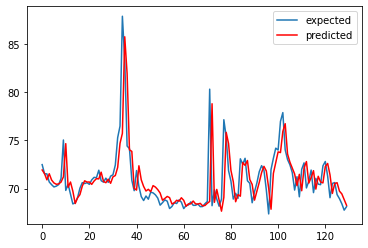

In [ ]:
# ARIMA с параметрами (5,1,1)
history = [x for x in xTrain]
predictions =list()
train_time = 0
predict_time = 0
for t in range(len(xTest)):
    start = time.time()
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit()
    end = time.time()
    train_time += (end - start)
    start = time.time()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    end = time.time()
    predict_time += (end - start)
    obs = xTest[t]
    history.append(obs)
    print(f'predicted = {yhat}, expected = {obs[0]}')    
rmse = sqrt(mean_squared_error(xTest, predictions))
mae = mean_absolute_error(xTest, predictions)
print(f'Время обучения ARIMA {round(train_time / 60, 2)} минут')
print(f'Время прогноза ARIMA {round(predict_time / 60, 2)} минут')
print(f'ARIMA Test RMSE: {round(rmse, 3)}')
print(f'ARIMA Test MAE: {round(mae, 3)}')
plt.plot(xTest, label='expected')
plt.plot(predictions, color='red', label='predicted')
plt.legend()
plt.show()

Проведем подбор гиперпараметров с помощью auto_arima

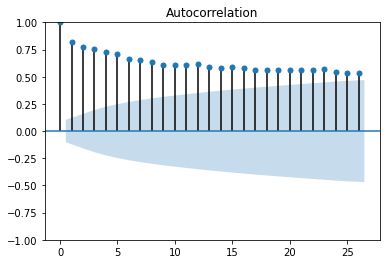

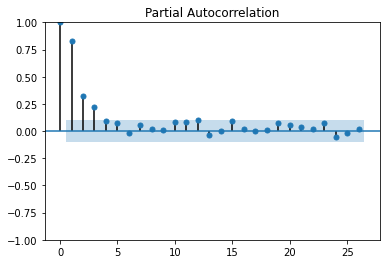

In [ ]:
# графики автокорреляции
plot_acf(data_res_ffill)
plot_pacf(data_res_ffill)
plt.show()

In [ ]:
# разделим данные на тренировочную и тестовую выборки
X = data_res_mean #.values
valLen = 130
trainLen = len(X) - valLen
xTrain, xTest = X[0:trainLen], X[trainLen:len(X)]

In [ ]:
print(f'Размер обучающей выборки: {xTrain.shape}')
print(f'Размер тестовой выборки: {xTest.shape}')

Размер обучающей выборки: (230, 1)
Размер тестовой выборки: (130, 1)


In [ ]:
model = auto_arima(xTrain,
                   start_p=1, start_d=1, start_q=1,
                   max_p=60, max_d=60, max_q=60,
                   seasonal=True, m=5,
                   start_P=0, start_D=0, start_Q=0,
                   max_P=2, max_D=2, max_Q=2,
                   trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=1245.406, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=1256.131, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=1256.438, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=1256.041, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=1254.273, Time=0.01 sec
 ARIMA(1,1,1)(1,0,0)[5] intercept   : AIC=1246.563, Time=0.28 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=1246.592, Time=0.22 sec
 ARIMA(1,1,1)(1,0,1)[5] intercept   : AIC=1248.487, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=1256.679, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=1256.892, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=1247.155, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[5] intercept   : AIC=1247.176, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[5] intercept   : AIC=1257.162, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[5] intercept   : AIC=1257.703, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 5),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [ ]:
model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,-0.0260,0.017,-1.491,0.136,-0.060,0.008
ar.L1,0.7838,0.054,14.430,0.000,0.677,0.890
ma.L1,-0.9459,0.044,-21.447,0.000,-1.032,-0.859
sigma2,12.9807,0.850,15.270,0.000,11.315,14.647


In [ ]:
model = sm.tsa.ARIMA(xTrain,
                                order=(1, 1, 1))

model_fit = model.fit()

print(model_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7681      0.065     11.800      0.000       0.641       0.896
ma.L1         -0.9204      0.065    -14.189      0.000      -1.048      -0.793
sigma2        13.1276      0.897     14.629      0.000      11.369      14.886


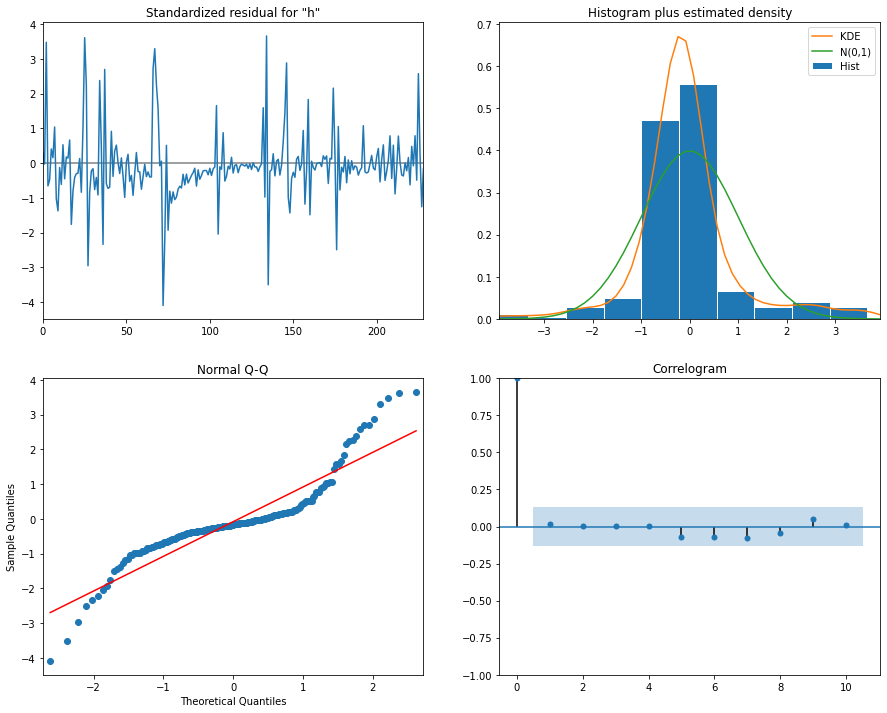

In [ ]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
predict=model_fit.get_prediction()
predict.predicted_mean[:10]

0 days 12:30:01.961000      0.000000
0 days 12:31:01.961000     93.202259
0 days 12:32:01.961000     94.167528
0 days 12:33:01.961000     93.991891
0 days 12:34:01.961000    105.224261
0 days 12:35:01.961000    101.889535
0 days 12:36:01.961000     99.638028
0 days 12:37:01.961000    100.557961
0 days 12:38:01.961000    100.612179
0 days 12:39:01.961000    103.480938
Freq: T, Name: predicted_mean, dtype: float64

predicted = 71.86982327703576, expected = 72.49014027777781
predicted = 72.32844238254278, expected = 71.53929166666666
predicted = 71.53498883523466, expected = 71.52821549295777
predicted = 71.52592390171621, expected = 70.68794225352114
predicted = 70.81354672342744, expected = 70.40887428571429
predicted = 70.56679535831357, expected = 70.17245285714284
predicted = 70.35365271067248, expected = 70.25542571428572
predicted = 70.4096070630451, expected = 70.41858450704227
predicted = 70.53573502399794, expected = 71.05623943661978
predicted = 71.06714074387779, expected = 75.04826621621622
predicted = 74.45028140896636, expected = 69.81266000000002
predicted = 70.0646197905715, expected = 70.4509357142857
predicted = 70.58392715711776, expected = 69.44225571428574
predicted = 69.72073398393943, expected = 68.408475
predicted = 68.8238936977598, expected = 68.53639565217387
predicted = 68.89864440075522, expected = 69.06204782608692
predicted = 69.31429485744987, expected = 70.0344799

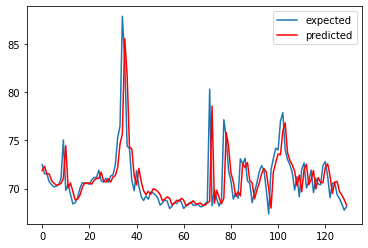

In [ ]:
# ARIMA с параметрами, подобранными auto_arima (1,1,1)
X = data_res_mean.values
valLen = 130
trainLen = len(X) - valLen
xTrain, xTest = X[0:trainLen], X[trainLen:len(X)]
history = [x for x in xTrain]
predictions =list()
train_time = 0
predict_time = 0
for t in range(len(xTest)):
    start = time.time()
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    end = time.time()
    train_time += (end - start)
    start = time.time()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    end = time.time()
    predict_time += (end - start)
    obs = xTest[t]
    history.append(obs)
    print(f'predicted = {yhat}, expected = {obs[0]}')    
rmse = sqrt(mean_squared_error(xTest, predictions))
mae = mean_absolute_error(xTest, predictions)
print(f'Время обучения ARIMA {round(train_time / 60, 2)} минут')
print(f'Время прогноза ARIMA {round(predict_time / 60, 2)} минут')
print(f'ARIMA Test RMSE: {round(rmse, 3)}')
print(f'ARIMA Test MAE: {round(mae, 3)}')
plt.plot(xTest, label='expected')
plt.plot(predictions, color='red', label='predicted')
plt.legend()
plt.show()

SARIMA

In [ ]:
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

predicted = 71.86982327703576, expected = 72.49014027777781
predicted = 72.32844238254278, expected = 71.53929166666666
predicted = 71.53498883523466, expected = 71.52821549295777
predicted = 71.52592390171621, expected = 70.68794225352114
predicted = 70.81354672342744, expected = 70.40887428571429
predicted = 70.56679535831357, expected = 70.17245285714284
predicted = 70.35365271067248, expected = 70.25542571428572
predicted = 70.4096070630451, expected = 70.41858450704227
predicted = 70.53573502399794, expected = 71.05623943661978
predicted = 71.06714074387779, expected = 75.04826621621622
predicted = 74.45028140896636, expected = 69.81266000000002
predicted = 70.0646197905715, expected = 70.4509357142857
predicted = 70.58392715711776, expected = 69.44225571428574
predicted = 69.72073398393943, expected = 68.408475
predicted = 68.8238936977598, expected = 68.53639565217387
predicted = 68.89864440075522, expected = 69.06204782608692
predicted = 69.31429485744987, expected = 70.0344799

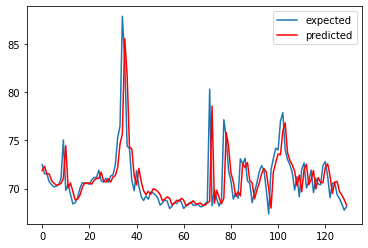

In [ ]:
# построим модель SARIMA, найдем RMSE, MAE, расчитаем время обучения и прогноза, визуализируем предсказание и ожидаемый результат
history = [x for x in xTrain]
predictions =list()
train_time = 0
predict_time = 0
for t in range(len(xTest)):
    start = time.time()
    model = SARIMAX(history, order=(1,1,1), seasonal_order=(0,0,0,5))
    model_fit = model.fit()
    end = time.time()
    train_time += (end - start)
    start = time.time()
    yhat = model_fit.predict(len(history), len(history))
    predictions.append(yhat[0])
    end = time.time()
    predict_time += (end - start)
    obs = xTest[t]
    history.append(obs)
    print(f'predicted = {yhat[0]}, expected = {obs[0]}')   
print(model_fit.summary().tables[1]) 
rmse = sqrt(mean_squared_error(xTest, predictions))
mae = mean_absolute_error(xTest, predictions)
print(f'Время обучения SARIMA {round(train_time / 60, 2)} минут')
print(f'Время прогноза SARIMA {round(predict_time / 60, 2)} минут')
print(f'SARIMA Test RMSE: {round(rmse, 3)}')
print(f'SARIMA Test MAE: {round(mae, 3)}')
plt.plot(xTest, label='expected')
plt.plot(predictions, color='red', label='predicted')
plt.legend()
plt.show()

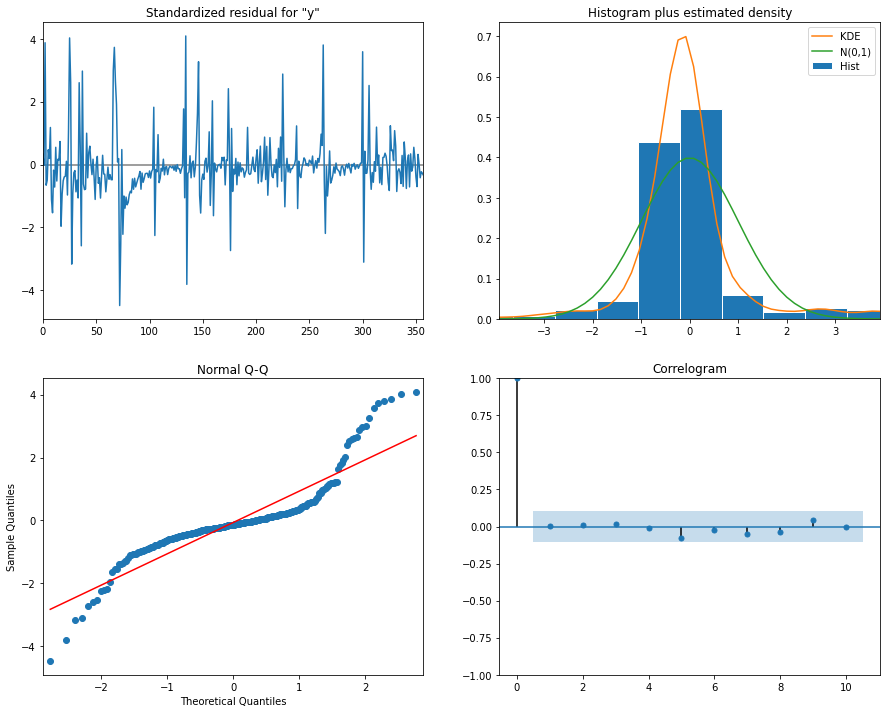

In [ ]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

Подбор гиперпараметров SARIMA

In [ ]:
# функция оучения и предсказания SARIMA (1 шаг)
def sarima_forecast(history, config):
    order, sorder, trend = config
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend)
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# функция ошибок
def measure_errors(actual, predicted):
    rmse = sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae

# функция разделения данных на обучающую и тестовую выборки
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# функция обучения и предсказания SARIMA (на всех данных в цикле), возвращает rmse, mae
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        yhat = sarima_forecast(history, cfg)
        predictions.append(yhat)
        history.append(test[i])
    rmse, mae = measure_errors(test, predictions)
    return rmse, mae

# функция оценки модели, возвращает None в случае неудачи
def score_model(data, n_test, cfg, debug=False):
    result1 = None
    result2 = None
    key = str(cfg)
    if debug:
        result1, result2 = walk_forward_validation(data, n_test, cfg)
    else:
        try:
            with catch_warnings():
                filterwarnings("ignore")
                result1, result2 = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    if result1 is not None:
        print(f'Model[{key}] RMSE = {round(result1, 3)} MAE = {round(result2, 3)}')
    return (key, result1, result2)

# функция конфигурации поиска по сетке
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda tup: tup[1])
    return scores

# функция создания списка гиперпараметров
def sarima_configs(seasonal=[2]):
    models = list()
    p_params = [0, 5, 20]
    d_params = [0, 1]
    q_params = [1, 2]
    t_params = ['n', 'c', 't', 'ct']
    P_params = [2, 5, 20]
    D_params = [2, 5]
    Q_params = [2, 3]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models    

In [ ]:
# data_res = data_copy.resample('min').mean()
data = data_copy.values
print(data.shape)
n_test = 130
cfg_list = sarima_configs()
scores = grid_search(data, cfg_list, n_test)
print("done")

(360, 1)
Model[[(0, 0, 1), (2, 2, 2, 2), 'c']] RMSE = 2.62 MAE = 1.491
Model[[(0, 0, 1), (2, 2, 2, 2), 't']] RMSE = 2.618 MAE = 1.495
Model[[(0, 0, 1), (2, 2, 3, 2), 'n']] RMSE = 2.629 MAE = 1.559
Model[[(0, 0, 1), (2, 2, 2, 2), 'ct']] RMSE = 2.678 MAE = 1.55
Model[[(0, 1, 1), (2, 2, 3, 2), 'n']] RMSE = 2.55 MAE = 1.43
Model[[(0, 0, 1), (2, 2, 3, 2), 'c']] RMSE = 2.626 MAE = 1.544
Model[[(0, 0, 1), (2, 2, 3, 2), 't']] RMSE = 2375194872.868 MAE = 208318372.597
Model[[(0, 0, 1), (5, 2, 2, 2), 'n']] RMSE = 2.654 MAE = 1.577
Model[[(0, 0, 1), (2, 2, 3, 2), 'ct']] RMSE = 2.662 MAE = 1.54
Model[[(0, 0, 1), (5, 2, 3, 2), 'n']] RMSE = 2.742 MAE = 1.609
Model[[(0, 1, 1), (2, 2, 3, 2), 'c']] RMSE = 2.564 MAE = 1.451
Model[[(0, 0, 1), (5, 2, 2, 2), 'c']] RMSE = 2.652 MAE = 1.56
Model[[(0, 0, 1), (5, 2, 3, 2), 'c']] RMSE = 2.759 MAE = 1.619
Model[[(0, 1, 1), (2, 2, 2, 2), 't']] RMSE = 3.383 MAE = 2.027
Model[[(0, 1, 1), (5, 2, 3, 2), 'n']] RMSE = 2.591 MAE = 1.477
Model[[(0, 1, 1), (2, 2, 2, 2), '

Подбор гиперпараметров данным способом, к сожалению занял несколько десятков часов и так и не завершился

In [ ]:
print("Три наилучших результата:")
for cfg, rmse, mae in scores[:3]:
    print(cfg, rmse, mae)

Попробуем подобрать гиперпараметры с помощью auto_arima

In [ ]:
model = auto_arima(xTrain,
                   start_p=0, start_d=0, start_q=0,
                   max_p=60, max_d=60, max_q=60,
                   seasonal=True, m=12,
                   start_P=0, start_D=0, start_Q=0,
                   max_P=2, max_D=2, max_Q=2,
                   trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1256.131, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1257.571, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1257.421, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1254.273, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1256.839, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1256.881, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1258.788, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1256.892, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1256.679, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1245.406, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1245.891, Time=0.48 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1245.993, Time=0.47 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1247.713, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1247.155, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [ ]:
model = sm.tsa.statespace.SARIMAX(xTrain,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12))

model_fit = model.fit()

print(model_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7681      0.065     11.800      0.000       0.641       0.896
ma.L1         -0.9204      0.065    -14.189      0.000      -1.048      -0.793
sigma2        13.1276      0.897     14.629      0.000      11.369      14.886


predicted = 71.86982327703576, expected = 72.49014027777781
predicted = 72.32844238254278, expected = 71.53929166666666
predicted = 71.53498883523466, expected = 71.52821549295777
predicted = 71.52592390171621, expected = 70.68794225352114
predicted = 70.81354672342744, expected = 70.40887428571429
predicted = 70.56679535831357, expected = 70.17245285714284
predicted = 70.35365271067248, expected = 70.25542571428572
predicted = 70.4096070630451, expected = 70.41858450704227
predicted = 70.53573502399794, expected = 71.05623943661978
predicted = 71.06714074387779, expected = 75.04826621621622
predicted = 74.45028140896636, expected = 69.81266000000002
predicted = 70.0646197905715, expected = 70.4509357142857
predicted = 70.58392715711776, expected = 69.44225571428574
predicted = 69.72073398393943, expected = 68.408475
predicted = 68.8238936977598, expected = 68.53639565217387
predicted = 68.89864440075522, expected = 69.06204782608692
predicted = 69.31429485744987, expected = 70.0344799

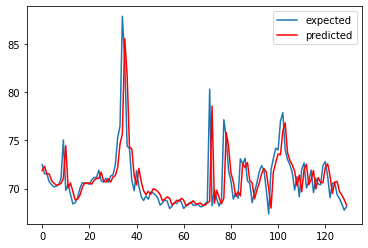

In [ ]:
# SARIMA с лучшими гиперпараметрами, подобранными auto_arima (1,1,1) (0,0,0,12) 
# параметр m, отражающий период (сезонность) может быть и другим, например 5, по-моему этот параметр не сильно влияет на результаты, т.к. в данных нет сезонности
history = [x for x in xTrain]
predictions =list()
train_time = 0
predict_time = 0
for t in range(len(xTest)):
    start = time.time()
    model = SARIMAX(history, order=(1,1,1), seasonal_order=(0,0,0,12))
    model_fit = model.fit()
    end = time.time()
    train_time += (end - start)
    start = time.time()
    yhat = model_fit.predict(len(history), len(history))
    predictions.append(yhat[0])
    end = time.time()
    predict_time += (end - start)
    obs = xTest[t]
    history.append(obs)
    print(f'predicted = {yhat[0]}, expected = {obs[0]}')   
print(model_fit.summary().tables[1]) 
rmse = sqrt(mean_squared_error(xTest, predictions))
mae = mean_absolute_error(xTest, predictions)
print(f'Время обучения SARIMA {round(train_time / 60, 2)} минут')
print(f'Время прогноза SARIMA {round(predict_time / 60, 2)} минут')
print(f'SARIMA Test RMSE: {round(rmse, 3)}')
print(f'SARIMA Test MAE: {round(mae, 3)}')
plt.plot(xTest, label='expected')
plt.plot(predictions, color='red', label='predicted')
plt.legend()
plt.show()

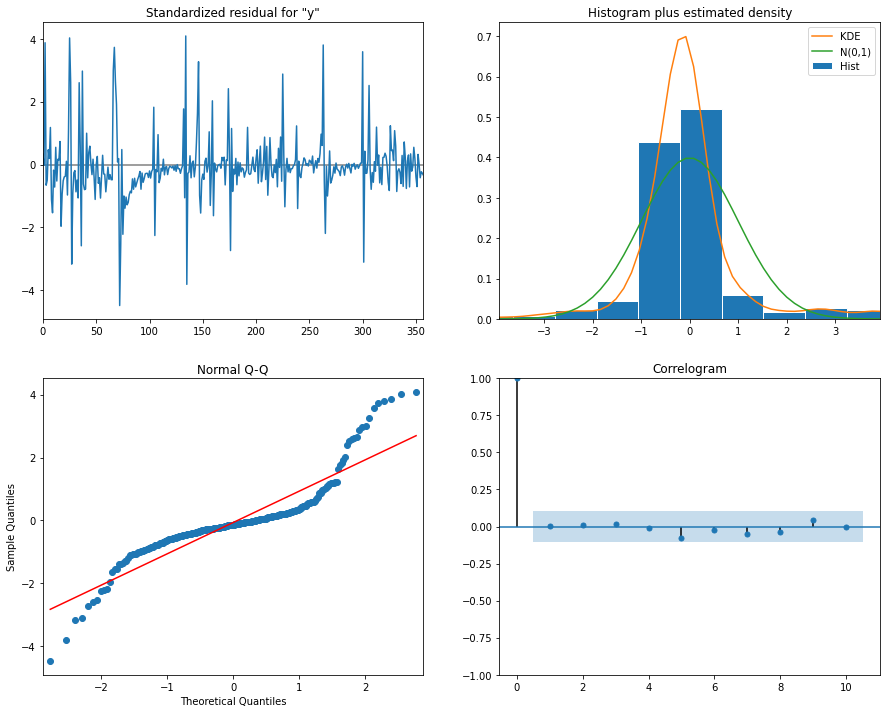

In [ ]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

# Neural Networks

LSTM

In [ ]:
# функция нарезки данных в массивы X,y для подачи в LSTM слой
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
# разделим данные на тренировочную и тестовую выборки
X = data_res_mean.values
valLen = 120
trainLen = len(X) - valLen
xTrain, xTest = X[0:trainLen], X[trainLen:len(X)]

In [ ]:
# подготовка датасетов
n_steps = 5
XTrain, yTrain = split_sequence(xTrain, n_steps)
XTest, yTest = split_sequence(xTest, n_steps)

In [ ]:
for i in range(len(XTrain)):
    print(XTrain[i], yTrain[i])

In [ ]:
n_features = 1
XTrain = XTrain.reshape(XTrain.shape[0], XTrain.shape[1], n_features)
XTest = XTest.reshape(XTest.shape[0], XTest.shape[1], n_features)

Время обучения LSTM 0.35 минут


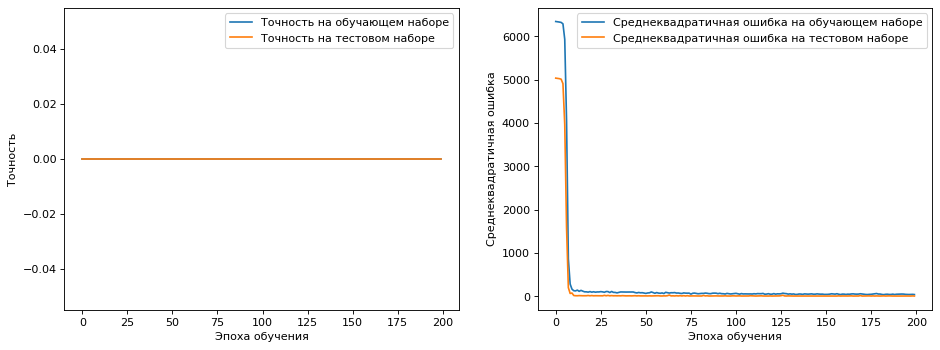

In [ ]:
start = time.time()
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
model.add(LSTM(2, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
# model.add(BatchNormalization())
model.add(Dense(1, activation='relu'))
model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics='accuracy')
history = model.fit(XTrain, yTrain, epochs=200, verbose=0, validation_data=(XTest, yTest))
end = time.time()
train_time = end - start
print(f'Время обучения LSTM {round(train_time / 60, 2)} минут')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5), dpi=80)
ax[0].plot(history.history['accuracy'], label='Точность на обучающем наборе')
ax[0].plot(history.history['val_accuracy'], label='Точность на тестовом наборе')
ax[0].set_xlabel('Эпоха обучения')
ax[0].set_ylabel('Точность')
ax[0].legend(loc='best')
ax[1].plot(history.history['loss'], label='Среднеквадратичная ошибка на обучающем наборе')
ax[1].plot(history.history['val_loss'], label='Среднеквадратичная ошибка на тестовом наборе')
ax[1].set_xlabel('Эпоха обучения')
ax[1].set_ylabel('Среднеквадратичная ошибка')
ax[1].legend(loc='best')


predicted = [[68.49278]] expected = [69.06204783]
predicted = [[68.89029]] expected = [70.03448]
predicted = [[69.56271]] expected = [70.61864714]
predicted = [[70.12368]] expected = [70.52227143]
predicted = [[70.253815]] expected = [70.61082535]
predicted = [[70.42639]] expected = [70.44158429]
predicted = [[70.43379]] expected = [70.90435915]
predicted = [[70.81794]] expected = [71.16891972]
predicted = [[71.09604]] expected = [71.13100423]
predicted = [[71.13657]] expected = [71.90901806]
predicted = [[71.73463]] expected = [70.82127324]
predicted = [[71.07134]] expected = [70.66897286]
predicted = [[70.8352]] expected = [71.08574789]
predicted = [[71.11858]] expected = [70.6501]
predicted = [[70.876785]] expected = [71.29316338]
predicted = [[71.199295]] expected = [71.43335493]
predicted = [[71.41478]] expected = [72.44611944]
predicted = [[72.26067]] expected = [75.292364]
predicted = [[74.52404]] expected = [76.49539474]
predicted = [[76.18336]] expected = [87.90154368]
predict

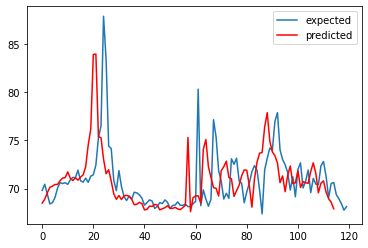

In [ ]:
start = time.time()
predictions =list()
for i in range(XTest.shape[0]):
    example = np.expand_dims(XTest[i], axis=0)
    yhat = model.predict(example, verbose=0)
    predictions.append(yhat[0])
    print(f'predicted = {yhat} expected = {yTest[i]}')
end = time.time()
predict_time = end - start
rmse = sqrt(mean_squared_error(yTest, predictions))
mae = mean_absolute_error(yTest, predictions)
print(f'Время обучения LSTM модели {round(train_time / 60, 2)} минут')
print(f'Время прогноза LSTM модели {round(predict_time / 60, 2)} минут')
print(f'LSTM Test RMSE: {round(rmse, 3)}')
print(f'LSTM Test MAE: {round(mae, 3)}')
plt.plot(xTest, label='expected')
plt.plot(predictions, color='red', label='predicted')
plt.legend()
plt.show()

При увеличении количества шагов при нарезке датасетов до 20, результаты стали хуже

In [ ]:
# разделим данные на тренировочную и тестовую выборки
X = data_res_mean.values
valLen = 120
trainLen = len(X) - valLen
xTrain, xTest = X[0:trainLen], X[trainLen:len(X)]

In [ ]:
# подготовка датасетов
n_steps = 20
XTrain, yTrain = split_sequence(xTrain, n_steps)
XTest, yTest = split_sequence(xTest, n_steps)

In [ ]:
n_features = 1
XTrain = XTrain.reshape(XTrain.shape[0], XTrain.shape[1], n_features)
XTest = XTest.reshape(XTest.shape[0], XTest.shape[1], n_features)

Время обучения LSTM 0.56 минут


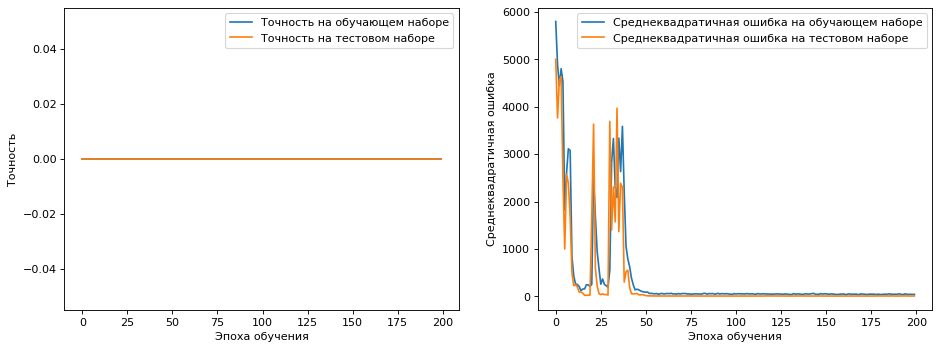

In [ ]:
start = time.time()
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
model.add(LSTM(2, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
# model.add(BatchNormalization())
model.add(Dense(1, activation='relu'))
model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics='accuracy')
history = model.fit(XTrain, yTrain, epochs=200, verbose=0, validation_data=(XTest, yTest))
end = time.time()
train_time = end - start
print(f'Время обучения LSTM {round(train_time / 60, 2)} минут')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5), dpi=80)
ax[0].plot(history.history['accuracy'], label='Точность на обучающем наборе')
ax[0].plot(history.history['val_accuracy'], label='Точность на тестовом наборе')
ax[0].set_xlabel('Эпоха обучения')
ax[0].set_ylabel('Точность')
ax[0].legend(loc='best')
ax[1].plot(history.history['loss'], label='Среднеквадратичная ошибка на обучающем наборе')
ax[1].plot(history.history['val_loss'], label='Среднеквадратичная ошибка на тестовом наборе')
ax[1].set_xlabel('Эпоха обучения')
ax[1].set_ylabel('Среднеквадратичная ошибка')
ax[1].legend(loc='best')


predicted = [[69.822754]] expected = [71.43335493]
predicted = [[69.972885]] expected = [72.44611944]
predicted = [[70.49828]] expected = [75.292364]
predicted = [[72.24693]] expected = [76.49539474]
predicted = [[73.66399]] expected = [87.90154368]
predicted = [[78.09437]] expected = [83.35865854]
predicted = [[78.65574]] expected = [74.42239459]
predicted = [[72.85034]] expected = [74.15097945]
predicted = [[71.53292]] expected = [70.8599169]
predicted = [[70.50817]] expected = [69.78435857]
predicted = [[70.0363]] expected = [71.87359155]
predicted = [[70.278755]] expected = [70.22709286]
predicted = [[69.54549]] expected = [69.16860435]
predicted = [[68.86652]] expected = [68.76021014]
predicted = [[68.90931]] expected = [69.2302913]
predicted = [[69.30801]] expected = [68.8995029]
predicted = [[69.333664]] expected = [69.62367]
predicted = [[69.58263]] expected = [69.55732609]
predicted = [[69.50927]] expected = [69.35105652]
predicted = [[69.383514]] expected = [69.01308986]
pred

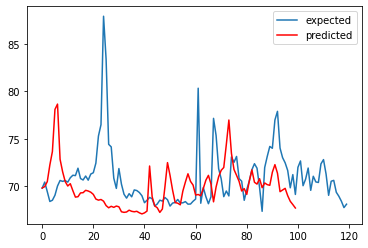

In [ ]:
start = time.time()
predictions =list()
for i in range(XTest.shape[0]):
    example = np.expand_dims(XTest[i], axis=0)
    yhat = model.predict(example, verbose=0)
    predictions.append(yhat[0])
    print(f'predicted = {yhat} expected = {yTest[i]}')
end = time.time()
predict_time = end - start
rmse = sqrt(mean_squared_error(yTest, predictions))
mae = mean_absolute_error(yTest, predictions)
print(f'Время обучения LSTM модели {round(train_time / 60, 2)} минут')
print(f'Время прогноза LSTM модели {round(predict_time / 60, 2)} минут')
print(f'LSTM Test RMSE: {round(rmse, 3)}')
print(f'LSTM Test MAE: {round(mae, 3)}')
plt.plot(xTest, label='expected')
plt.plot(predictions, color='red', label='predicted')
plt.legend()
plt.show()

Попробуем изменить некоторые данные: n_steps = 2, lr=1e-4, LSTM(10 нейронов)

In [ ]:
# разделим данные на тренировочную и тестовую выборки
X = data_res_mean.values
valLen = 120
trainLen = len(X) - valLen
xTrain, xTest = X[0:trainLen], X[trainLen:len(X)]

In [ ]:
# подготовка датасетов
n_steps = 2
XTrain, yTrain = split_sequence(xTrain, n_steps)
XTest, yTest = split_sequence(xTest, n_steps)

In [ ]:
n_features = 1
XTrain = XTrain.reshape(XTrain.shape[0], XTrain.shape[1], n_features)
XTest = XTest.reshape(XTest.shape[0], XTest.shape[1], n_features)

In [ ]:
XTrain.shape

(238, 2, 1)

In [ ]:
yTrain.shape

(238, 1)

Время обучения LSTM 0.18 минут


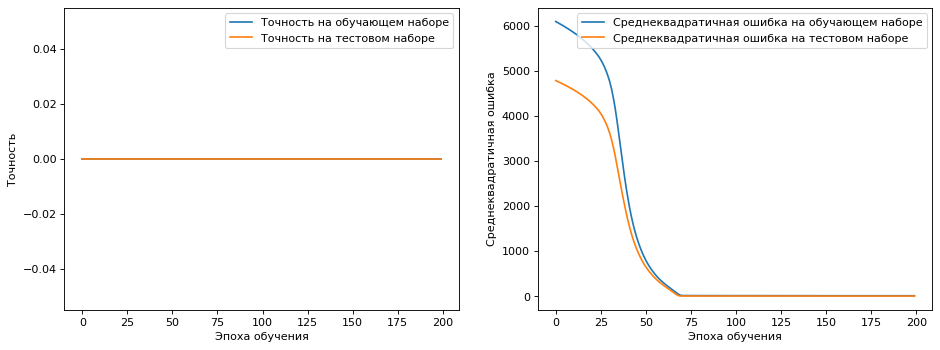

In [ ]:
start = time.time()
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(n_steps, n_features))) #, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
# model.add(LSTM(2, activation='relu'))
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
model.add(Dense(1, activation='relu'))
model.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics='accuracy')
history = model.fit(XTrain, yTrain, epochs=200, verbose=0, validation_data=(XTest, yTest))
end = time.time()
train_time = end - start
print(f'Время обучения LSTM {round(train_time / 60, 2)} минут')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5), dpi=80)
ax[0].plot(history.history['accuracy'], label='Точность на обучающем наборе')
ax[0].plot(history.history['val_accuracy'], label='Точность на тестовом наборе')
ax[0].set_xlabel('Эпоха обучения')
ax[0].set_ylabel('Точность')
ax[0].legend(loc='best')
ax[1].plot(history.history['loss'], label='Среднеквадратичная ошибка на обучающем наборе')
ax[1].plot(history.history['val_loss'], label='Среднеквадратичная ошибка на тестовом наборе')
ax[1].set_xlabel('Эпоха обучения')
ax[1].set_ylabel('Среднеквадратичная ошибка')
ax[1].legend(loc='best')


predicted = [[70.92299]] expected = [69.44225571]
predicted = [[70.23469]] expected = [68.408475]
predicted = [[69.17378]] expected = [68.53639565]
predicted = [[69.065025]] expected = [69.06204783]
predicted = [[69.515625]] expected = [70.03448]
predicted = [[70.41018]] expected = [70.61864714]
predicted = [[71.10874]] expected = [70.52227143]
predicted = [[71.16427]] expected = [70.61082535]
predicted = [[71.21498]] expected = [70.44158429]
predicted = [[71.09689]] expected = [70.90435915]
predicted = [[71.43141]] expected = [71.16891972]
predicted = [[71.74873]] expected = [71.13100423]
predicted = [[71.77651]] expected = [71.90901806]
predicted = [[72.38729]] expected = [70.82127324]
predicted = [[71.6631]] expected = [70.66897286]
predicted = [[71.326866]] expected = [71.08574789]
predicted = [[71.62851]] expected = [70.6501]
predicted = [[71.36592]] expected = [71.29316338]
predicted = [[71.78811]] expected = [71.43335493]
predicted = [[72.047646]] expected = [72.44611944]
predic

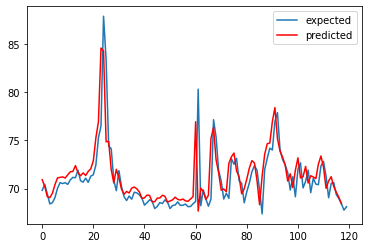

In [ ]:
start = time.time()
predictions =list()
for i in range(XTest.shape[0]):
    example = np.expand_dims(XTest[i], axis=0)
    yhat = model.predict(example, verbose=0)
    predictions.append(yhat[0])
    print(f'predicted = {yhat} expected = {yTest[i]}')
end = time.time()
predict_time = end - start
rmse = sqrt(mean_squared_error(yTest, predictions))
mae = mean_absolute_error(yTest, predictions)
print(f'Время обучения LSTM модели {round(train_time / 60, 2)} минут')
print(f'Время прогноза LSTM модели {round(predict_time / 60, 2)} минут')
print(f'LSTM Test RMSE: {round(rmse, 3)}')
print(f'LSTM Test MAE: {round(mae, 3)}')
plt.plot(xTest, label='expected')
plt.plot(predictions, color='red', label='predicted')
plt.legend()
plt.show()

LSTM(64), 1 Dense layer, optimizer=RMSprop

In [ ]:
# разделим данные на тренировочную и тестовую выборки
X = data_res_mean.values
valLen = 120
trainLen = len(X) - valLen
xTrain, xTest = X[0:trainLen], X[trainLen:len(X)]

In [ ]:
# подготовка датасетов
n_steps = 2
XTrain, yTrain = split_sequence(xTrain, n_steps)
XTest, yTest = split_sequence(xTest, n_steps)

In [ ]:
n_features = 1
XTrain = XTrain.reshape(XTrain.shape[0], XTrain.shape[1], n_features)
XTest = XTest.reshape(XTest.shape[0], XTest.shape[1], n_features)

In [ ]:
XTrain.shape

(238, 2, 1)

In [ ]:
yTrain.shape

(238, 1)

Время обучения LSTM 0.21 минут


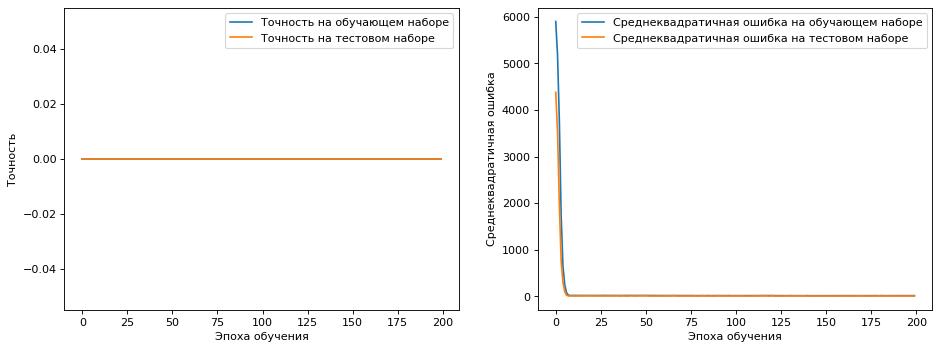

In [ ]:
start = time.time()
model = Sequential()
# model.add(Bidirectional(LSTM(56, activation='relu', input_shape=(n_steps, n_features)))) #, return_sequences=True))
model.add(LSTM(64, activation='relu', input_shape=(n_steps, n_features))) #, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
# model.add(LSTM(2, activation='relu'))
# model.add(Dense(24, activation='relu'))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
model.add(Dense(1, activation='relu'))
model.compile(optimizer=RMSprop(lr=1e-3), loss='mse', metrics='accuracy')
history = model.fit(XTrain, yTrain, epochs=200, verbose=0, validation_data=(XTest, yTest))
end = time.time()
train_time = end - start
print(f'Время обучения LSTM {round(train_time / 60, 2)} минут')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5), dpi=80)
ax[0].plot(history.history['accuracy'], label='Точность на обучающем наборе')
ax[0].plot(history.history['val_accuracy'], label='Точность на тестовом наборе')
ax[0].set_xlabel('Эпоха обучения')
ax[0].set_ylabel('Точность')
ax[0].legend(loc='best')
ax[1].plot(history.history['loss'], label='Среднеквадратичная ошибка на обучающем наборе')
ax[1].plot(history.history['val_loss'], label='Среднеквадратичная ошибка на тестовом наборе')
ax[1].set_xlabel('Эпоха обучения')
ax[1].set_ylabel('Среднеквадратичная ошибка')
ax[1].legend(loc='best')


predicted = [[69.72153]] expected = [69.44225571]
predicted = [[69.299194]] expected = [68.408475]
predicted = [[68.24658]] expected = [68.53639565]
predicted = [[67.91138]] expected = [69.06204783]
predicted = [[68.29607]] expected = [70.03448]
predicted = [[69.13387]] expected = [70.61864714]
predicted = [[69.92212]] expected = [70.52227143]
predicted = [[70.09983]] expected = [70.61082535]
predicted = [[70.118614]] expected = [70.44158429]
predicted = [[70.04412]] expected = [70.90435915]
predicted = [[70.275055]] expected = [71.16891972]
predicted = [[70.63518]] expected = [71.13100423]
predicted = [[70.715935]] expected = [71.90901806]
predicted = [[71.20673]] expected = [70.82127324]
predicted = [[70.73284]] expected = [70.66897286]
predicted = [[70.27613]] expected = [71.08574789]
predicted = [[70.48554]] expected = [70.6501]
predicted = [[70.35435]] expected = [71.29316338]
predicted = [[70.611305]] expected = [71.43335493]
predicted = [[70.963135]] expected = [72.44611944]
pre

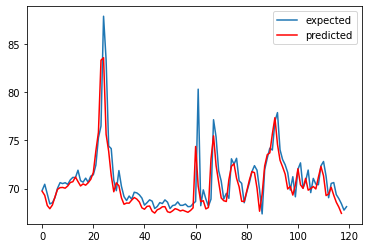

In [ ]:
start = time.time()
predictions =list()
for i in range(XTest.shape[0]):
    example = np.expand_dims(XTest[i], axis=0)
    yhat = model.predict(example, verbose=0)
    predictions.append(yhat[0])
    print(f'predicted = {yhat} expected = {yTest[i]}')
end = time.time()
predict_time = end - start
rmse = sqrt(mean_squared_error(yTest, predictions))
mae = mean_absolute_error(yTest, predictions)
print(f'Время обучения LSTM модели {round(train_time / 60, 2)} минут')
print(f'Время прогноза LSTM модели {round(predict_time / 60, 2)} минут')
print(f'LSTM Test RMSE: {round(rmse, 3)}')
print(f'LSTM Test MAE: {round(mae, 3)}')
plt.plot(xTest, label='expected')
plt.plot(predictions, color='red', label='predicted')
plt.legend()
plt.show()

# Заключение:
*   Статистические модели ARIMA, SARIMA, а также нейронная сеть с LSTM слоями покзывает близкий к ожидаемому результат, но такое впечатление, что повторяет данные предыдущих шагов. 
*   Подбор гиперпараметров ARIMA, SARIMA лучше всего проводить с помощью auto_arima. Самописные функции подбора гиперпараметров работают на порядок дольше.
*   В нейронной сети слои Dropout, BatchNormalization, Bidirectional значительно ухудшали результаты, как и увеличение кол-ва слоев

При выполнении проекта пользовалась следующими источниками:








ARIMA links:

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

SARIMA links:

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

https://github.com/aikula/f2forecast/blob/master/Course_f2forecast.ipynb

LSTM links:

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/